# Выбор локации для скважины



Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Краткая информация о данных и цели проекта:


* Проект представленн данными геологической разведки трёх регионов.

Общие признаки:


* **id - уникальный идентификатор скважины**
* **f0, f1, f2 - три признака точек, фактическое обозначение которых не разглашается**

Целевой признак:
* **product** объем запасов скважины(в тыс. баррелей)

Задача:

* **Выбрать локацию для бурения новой скважины**

Дополнительная информация по проекту определена примерными шагами для выбора локации:

* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

### Импорт 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats as st


In [2]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

### Geodata_1 предпросмотр:

In [3]:
display(df_1.head())
display(df_1.shape)
display(df_1.describe())
df_1.info()
print('\n','Количество дубликатов:',df_1.duplicated().sum())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


(100000, 5)

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 Количество дубликатов: 0


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

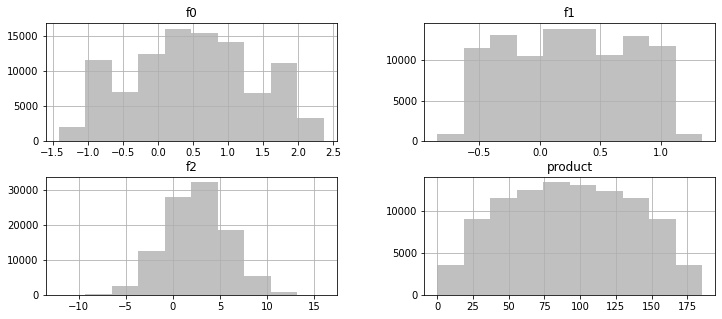

In [4]:
df_1.hist(figsize = (12,5), color = 'silver')

<AxesSubplot:>

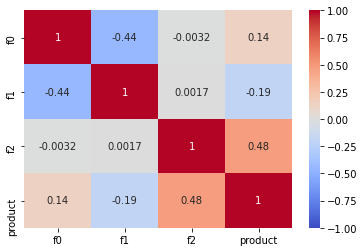

In [5]:
sns.heatmap(df_1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

### Geodata_2 предпросмотр:


In [6]:
display(df_2.head())
display(df_2.shape)
display(df_2.describe())
df_2.info()
print('\n','Количество дубликатов:',df_2.duplicated().sum())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


(100000, 5)

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 Количество дубликатов: 0


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

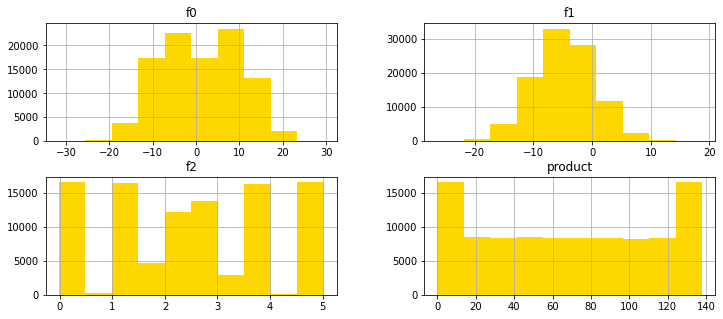

In [7]:
df_2.hist(figsize = (12,5), color = 'gold')

<AxesSubplot:>

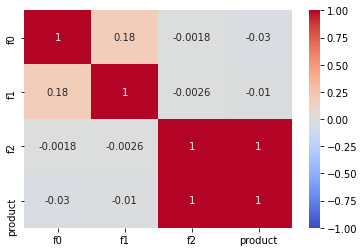

In [8]:
sns.heatmap(df_2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

### Geodata_3 предпросмотр:


In [9]:
display(df_3.head())
display(df_3.shape)
display(df_3.describe())
df_3.info()
print('\n','Количество дубликатов:',df_3.duplicated().sum())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(100000, 5)

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 Количество дубликатов: 0


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>,
        <AxesSubplot:title={'center':'product'}>]], dtype=object)

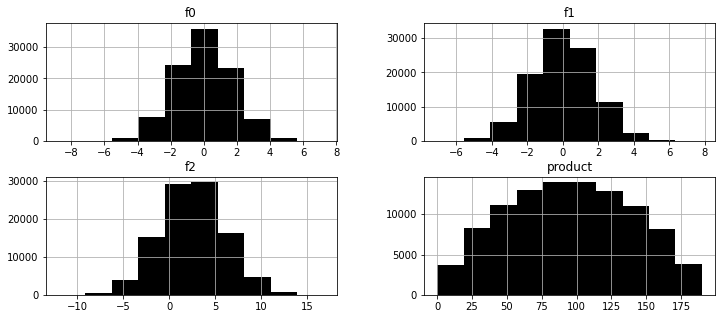

In [10]:
df_3.hist(figsize = (12,5), color = 'black')


<AxesSubplot:>

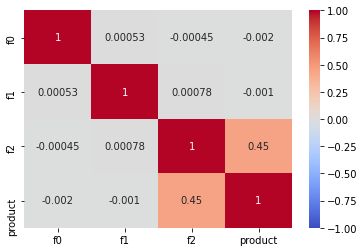

In [11]:
sns.heatmap(df_3.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

### Выводы:

* Ввиду особенностей описания признаков нет возможности судить о наличие ошибок в данных.
* В данных не наблюдается резко выдающихся значений.
* Гистограммы построенные по геоданным второго файла отличнаются от остальных двух.

<AxesSubplot:title={'center':'Production'}, ylabel='Frequency'>

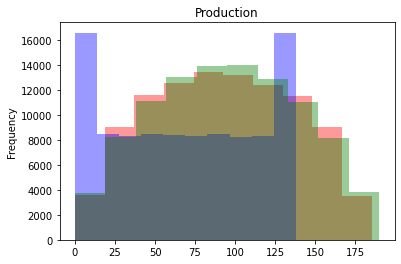

In [12]:
plt.title('Production')
df_1['product'].plot(kind = 'hist', color = 'red', alpha = 0.4)
df_2['product'].plot(kind = 'hist', color = 'blue',alpha = 0.4)
df_3['product'].plot(kind = 'hist', color = 'green', alpha = 0.4)

## Подготовка данных для модели:

* Столбец с уникальным идентификатором скважины не представляет для нас информативности. Предположим, что уникальный номер скважины может состоять из цифр - удалим его, чтобы не мешал обучению модели.


In [13]:
features_1 = df_1.drop(['id','product'], axis = 1)
target_1 = df_1['product']

features_2 = df_2.drop(['id','product'], axis = 1)
target_2 = df_2['product']

features_3 = df_3.drop(['id','product'], axis = 1)
target_3 = df_3['product']

* Разбиение выборки на обучающую и валидационную в соотношении 75:25

In [14]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size = 0.25, random_state = 12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size = 0.25, random_state = 12345)

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, target_3, test_size = 0.25, random_state = 12345)

In [15]:
print('Обучающая выборка первых геоданных. Признаки:',features_train_1.shape,
      ',целевой признак:', target_train_1.shape)
print('Валидационная выборка первых геоданных. Признаки:',features_valid_1.shape,
     ', целевой признак:', target_valid_1.shape,'\n')

print('Обучающая выборка вторых геоданных. Признаки:',features_train_2.shape,
      ',целевой признак:', target_train_2.shape)
print('Валидационная выборка вторых геоданных. Признаки:',features_valid_2.shape,
     ', целевой признак:', target_valid_2.shape,'\n')

print('Обучающая выборка третьих геоданных. Признаки:',features_train_3.shape,
      ',целевой признак:', target_train_3.shape)
print('Валидационная выборка третьих геоданных. Признаки:',features_valid_3.shape,
     ', целевой признак:', target_valid_3.shape,'\n')

Обучающая выборка первых геоданных. Признаки: (75000, 3) ,целевой признак: (75000,)
Валидационная выборка первых геоданных. Признаки: (25000, 3) , целевой признак: (25000,) 

Обучающая выборка вторых геоданных. Признаки: (75000, 3) ,целевой признак: (75000,)
Валидационная выборка вторых геоданных. Признаки: (25000, 3) , целевой признак: (25000,) 

Обучающая выборка третьих геоданных. Признаки: (75000, 3) ,целевой признак: (75000,)
Валидационная выборка третьих геоданных. Признаки: (25000, 3) , целевой признак: (25000,) 



## Обучение и проверка модели

*По условию - для обучения модели используется только линейная регрессия, т.к. остальные недостаточно предсказуемы.*

* Для каждого региона обучается отдельная модель, соответственно непересекающимся особенностям геоданных

### Geodata 1

In [16]:
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predict_1 = model.predict(features_valid_1)
mean_1 = predict_1.sum()/len(predict_1)
print('Средний запас скважины:', mean_1)
result_1 = mean_squared_error(target_valid_1, predict_1)**0.5
print('RMSE:', result_1)
r2_score_1 = r2_score(target_valid_1, predict_1)
print('R2:', r2_score_1)

Средний запас скважины: 92.59256778438035
RMSE: 37.5794217150813
R2: 0.27994321524487786


### Geodata 2

In [17]:
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predict_2 = model.predict(features_valid_2)
mean_2 = predict_2.sum()/len(predict_2)
print('Средний запас скважины:', mean_2)
result_2 = mean_squared_error(target_valid_2, predict_2)**0.5
print('RMSE:', result_2)
r2_score_2 = r2_score(target_valid_2, predict_2)
print('R2:', r2_score_2)

Средний запас скважины: 68.728546895446
RMSE: 0.893099286775617
R2: 0.9996233978805127


### Geodata 3

In [18]:
model = LinearRegression()
model.fit(features_train_3, target_train_3)
predict_3 = model.predict(features_valid_3)
mean_3 = predict_3.sum()/len(predict_3)
print('Средний запас скважины:', mean_3)
result_3 = mean_squared_error(target_valid_3, predict_3)**0.5
print('RMSE:', result_3)
r2_score_3 = r2_score(target_valid_3, predict_3)
print('R2:', r2_score_3)

Средний запас скважины: 94.96504596800489
RMSE: 40.02970873393434
R2: 0.20524758386040443


### Заключение:

In [19]:
compos = pd.DataFrame(index = ['Средний запас скважины', 'Среднеквадратическая ошибка (RMSE)','Коэффицент детерминации (R2)']
                      , columns = ['Geodata 1','Geodata 2','Geodata 3'])
compos['Geodata 1'] = mean_1, result_1, r2_score_1
compos['Geodata 2'] = mean_2, result_2, r2_score_2
compos['Geodata 3'] = mean_3, result_3, r2_score_3

In [20]:
compos

,Geodata 1,Geodata 2,Geodata 3
Средний запас скважины,92.592568,68.728547,94.965046
Среднеквадратическая ошибка (RMSE),37.579422,0.893099,40.029709
Коэффицент детерминации (R2),0.279943,0.999623,0.205248


* Исходя из метрики R2 - модель для второй геодаты практически идеально предсказывает значения запаса скважины, что видно и по среднеквадратичной ошибке.
* Модели, ориентированные на другие геодаты, значительно уступают второй.

## Подготовка к расчёту прибыли

Из условия задачи обознчим: 
* Цену на один борелль

In [21]:
one_product_income = 450

* Бюджет на разработку скважин, в тысячах

In [22]:
budget = 10000000

* Количество разрабатываемых скважин

In [23]:
object_count = 200

* Рассчитаем минимально необходимое, среднее количество бареллей(product) для окупаемости бюджета.

In [24]:
min_prob = budget/ object_count / one_product_income
min_prob

111.11111111111111

* Сравним среднее значение по регионам с полученной величиной:

In [25]:
mean_1r = df_1['product'].mean()
mean_2r = df_2['product'].mean()
mean_3r = df_3['product'].mean()

In [26]:
print('Запас среднего объема в первом регионе относительно необходимого минимума: {:.1f} %'.format((mean_1r/min_prob - 1)*100))
print('Запас среднего объема во втором регионе относительно необходимого минимума: {:.1f} %'.format((mean_2r/min_prob - 1)*100))
print('Запас среднего объема в третьем регионе относительно необходимого минимума:: {:.1f} %'.format((mean_3r/min_prob - 1)*100))

Запас среднего объема в первом регионе относительно необходимого минимума: -16.7 %
Запас среднего объема во втором регионе относительно необходимого минимума: -38.1 %
Запас среднего объема в третьем регионе относительно необходимого минимума:: -14.5 %


* **Средний объем скважин по всем регионам значительно меньше необходимого, для покрытия затрат на разработку.**

* **Для извлечения прибыли с разработки скважин - необходима модель предсказывающая объем месторождения.**

Из предсказаний моделей сделаем объект Series с индексами:

In [27]:
probs_1 = pd.Series(predict_1, index = target_valid_1.index)
probs_2 = pd.Series(predict_2, index = target_valid_2.index)
probs_3 = pd.Series(predict_3, index = target_valid_3.index)

## Расчёт прибыли и рисков 

### Рассчет прибыли по предсказаниям модели

In [28]:
# Cреди предсказаний модели отберём 200(default) лучших предсказаний 
# Подставим и просумируем фактический объем.

def oil_value(target, probs, count = object_count):
    probs_sorted = probs.sort_values(ascending = False)
    selected = target[probs_sorted.index][:count] #probs_sorted[:count]
    return selected.sum()

In [29]:
def profit(target, probs, count = object_count):
    print(f'Общий объём сырья в {count} лучших скважин:', oil_value(target, probs, count), 
          'тысяч барелей.')
    print('Ожидаемая прибыль от выбранных скважин, без вычета бюджета: ~',
          int((oil_value(target, probs, count) 
          * one_product_income)//1000), 'миллионов рублей.')
    print('Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~',
          int(((oil_value(target, probs, count) 
          * one_product_income) - budget)//1000), 'миллионов рублей.'  )

#### Geodata 1

In [30]:
profit(target_valid_1, probs_1 )

Общий объём сырья в 200 лучших скважин: 29601.83565142189 тысяч барелей.
Ожидаемая прибыль от выбранных скважин, без вычета бюджета: ~ 13320 миллионов рублей.
Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~ 3320 миллионов рублей.


#### Geodata 2

In [31]:
profit(target_valid_2, probs_2 )

Общий объём сырья в 200 лучших скважин: 27589.081548181137 тысяч барелей.
Ожидаемая прибыль от выбранных скважин, без вычета бюджета: ~ 12415 миллионов рублей.
Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~ 2415 миллионов рублей.


#### Geodata 3

In [32]:
profit(target_valid_1, probs_3)

Общий объём сырья в 200 лучших скважин: 19135.16501417992 тысяч барелей.
Ожидаемая прибыль от выбранных скважин, без вычета бюджета: ~ 8610 миллионов рублей.
Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~ -1390 миллионов рублей.


### Рассчет рисков и распределение прибыли

* Будет производиться техникой bootstrap с 1000 выборок для каждого региона:

In [33]:

def bootstrap(target, probs, count_sample = 500 , count_revenue = object_count, boots = 1000):

    state = np.random.RandomState(12345)
    values = []
    
    def revenue(target, probs, count):
        probs_sorted = probs.sort_values(ascending = False)
        selected = target[probs_sorted.index][:count]
        return (one_product_income * selected.sum()) - budget
    
    for i in range(boots):
        target_subsample = target.sample(n = count_sample, replace = True, random_state = state)
        probs_subsample = probs[target_subsample.index]
        values.append(revenue(target_subsample,probs_subsample,count_revenue))
        
    negative_sample = 0
    
    for n in values:
            if n < 0:
                negative_sample += 1
    
    values = pd.Series(values)
    mean = values.mean()
    #confidence_interval = st.t.interval(0.95, len(values), values.mean(), values.sem())
    danger = (negative_sample / boots) *100
    
    low = values.quantile(q = 0.025)
    high = values.quantile(q = 0.975)
    
    
    print('Средняя прибыль по региону равна: {:.2f} миллионов рублей. '.format(mean/1000))    
    #print('95% Доверительный интервал от: {:.3f} до {:.3f} миллионов рублей. '
    #                               .format(confidence_interval[0]/1000, confidence_interval[1]/1000))
    print('95% Доверительный интервал от: {:.3f} до {:.3f} миллионов рублей. '
                                  .format(low/1000,high/1000))
    print(f'Риск убытков составляет: {(danger)} %')
    
    
    values.hist(bins = 30, grid = True, color = 'purple', figsize = (10,7))
    plt.title('Распределение прибыли')
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.ticklabel_format(style='plain')

####  Geodata 1

Средняя прибыль по региону равна: 425.94 миллионов рублей. 
95% Доверительный интервал от: -102.090 до 947.976 миллионов рублей. 
Риск убытков составляет: 6.0 %


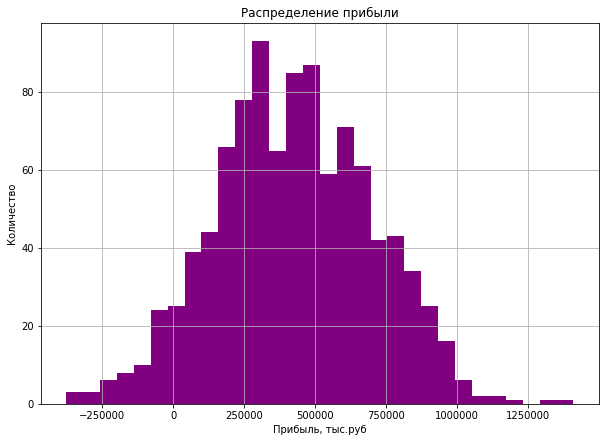

In [34]:
bootstrap(target_valid_1,probs_1)

#### Geodata 2

Средняя прибыль по региону равна: 515.22 миллионов рублей. 
95% Доверительный интервал от: 68.873 до 931.548 миллионов рублей. 
Риск убытков составляет: 1.0 %


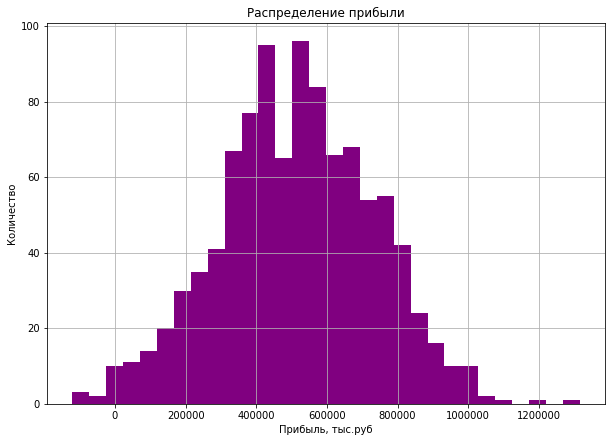

In [35]:
bootstrap(target_valid_2,probs_2)

#### Geodata 3

Средняя прибыль по региону равна: 435.01 миллионов рублей. 
95% Доверительный интервал от: -128.881 до 969.707 миллионов рублей. 
Риск убытков составляет: 6.4 %


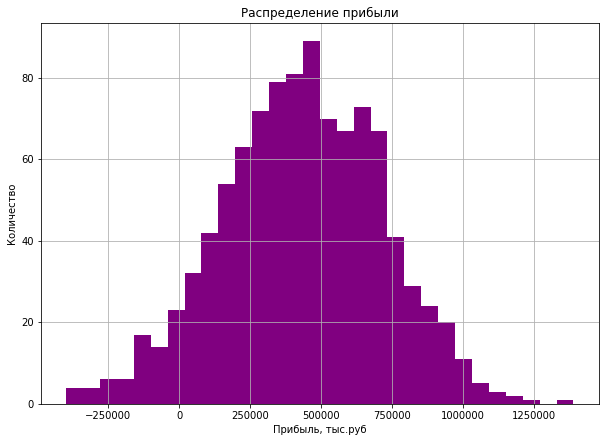

In [36]:
bootstrap(target_valid_3,probs_3)

### Сравнение

In [37]:
table = pd.DataFrame(index = ['Средняя прибыль по региону (миллионов рублей).','Риск убытков (%)', 'Коэффицент детерминации готовой модели'], 
                     columns = ['Geodata 1','Geodata 2', 'Geodata 3'] )
table['Geodata 1'] = '425.94', '6.0',r2_score_1
table['Geodata 2'] = '515.22', '1.0', r2_score_2
table['Geodata 3'] = '435.01', '6.4', r2_score_3


In [39]:
display(table)

,Geodata 1,Geodata 2,Geodata 3
Средняя прибыль по региону (миллионов рублей).,425.94,515.22,435.01
Риск убытков (%),6.0,1.0,6.4
Коэффицент детерминации готовой модели,0.279943,0.999623,0.205248


Text(0, 0.5, 'Миллионов рублей')

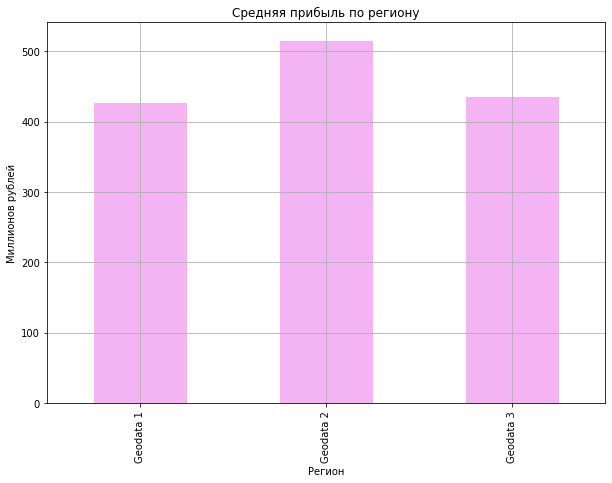

In [40]:
table.astype('float').iloc[0].plot(kind="bar", figsize=(10,7), grid=True, alpha=0.6, color = 'violet')
plt.title('Средняя прибыль по региону')
plt.xlabel('Регион')
plt.ylabel('Миллионов рублей')

Text(0, 0.5, '%')

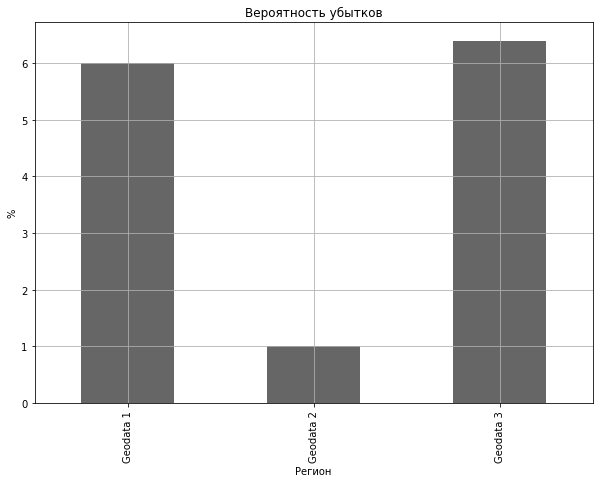

In [41]:
table.astype('float').iloc[1].plot(kind="bar", figsize=(10,7), grid=True, alpha=0.6, color = 'black')
plt.title('Вероятность убытков')
plt.xlabel('Регион')
plt.ylabel('%')

Text(0, 0.5, 'R2')

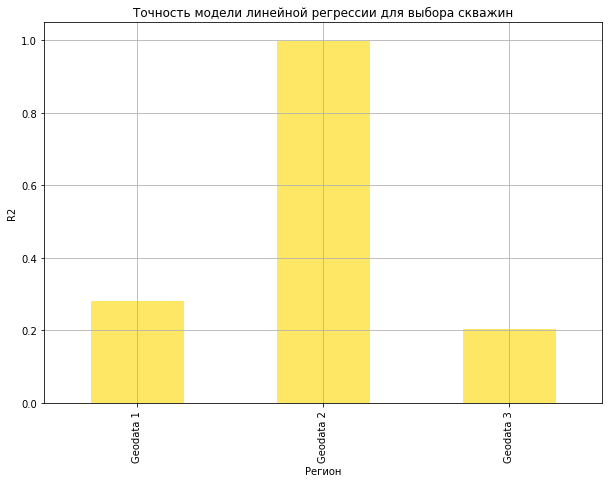

In [42]:
table.astype('float').iloc[2].plot(kind="bar", figsize=(10,7), grid=True, alpha=0.6, color = 'gold')
plt.title('Точность модели линейной регрессии для выбора скважин')
plt.xlabel('Регион')
plt.ylabel('R2')

### Вывод и выбор региона

Исходя из условий поставленной задачи: необходимо выбрать регионы, после оценки рисков которых, вероятность убытков не превышает 2.5%:

* **Основное условие заказчика выполняется только для второго региона, что отмечается как самый значимый фактор выбора. Риск убытков при разработке новых скважин во втором региона составил: 1%**.

Также второй регион отличается:

* **Наибольшей оценкой средней прибыли в 515.22 миллиона рублей.**

* **Модель линейной регрессии предсказывающая объем будущей скважины отличается минимальной погрешностью, позволяя наиболее достоверно выявлять объемные месторождения. R2 стремится к 1**

## Общий вывод

**Модели логистической регрессии для предсказания объема продукта в скважине:**

* Разница в точностях моделей логистической регрессии не позволяет сделать однозначный вывод по всем трём регионам, представленным в данных. Среднеквадратичная ошибка и коэффицент детерминации модели для второго региона составляют 0.89 RMSE и 0.99 R2. Что значительно опережает модели 1'го(Среднеквадратичная ошибка 37.5, R2 = 0.27) и 3'го региона(Среднеквадратичная ошибка 40, R2 = 0.20).


* Лучшие показатели среднего запаса в 1'ом и 3'ем регионе.Они опережают второй в среднем на ~22.000 бареллей. Что в будущем может быть компенсировано грамотным выбором месторождений по второй модели, когда первая и третья, основываясь на R2 статистике, работают приближено к среднему значению, а не правильности предсказания для каждой скважины.

**Оценка прибыли по результатам работы модели:**

* Наибольшая прибыль, исходя только из результатов предсказаний полученных моделей, для 200 лучших меторождений, распределена в следующем порядке:

1ое место:

* 1 регион: Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~ 3320 миллионов рублей. ROI = 0.3320

2e место:


* 2'ой регион: Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~ 2415 миллионов рублей. ROI = 0.2415

3е место:

* 3'ий регион: Ожидаемая прибыль от выбранных скважин, с вычетом бюджета: ~ -1390 миллионов рублей. ROI = -0.1390

**Заключение для рисков и прибыли в регионах по технике bootstrap с 1000 выборок**

Не смотря на позитивные прогнозы моделей логистической регрессии, лидером среди регионов по минимальному риску стал:

* 2'ой регион, показавший **вероятность убытков в 1%**. Как и по средней выручке, среди 1000 выборок скважин на участке, с результатом в **515.22 миллионов рублей** в **95% доверительном интервале от: 501.621 до 528.824 миллионов рублей.**

**Итоговое заключение:**

* Под условия задачи, регион с наименьшим риском убытков, подходящий для разработки скважин - 2ой(geo_data_1.csv). 
* Разработка скважин в регионе 1(geo_data_0) и регионе 3(geo_data_2) более рискована и даёт меньшую среднюю прибыль.


**Дополнительный комментарий:**

* Отдельный плюс для выбора второго региона - модель логистичесткой регрессии, точность которой стремиться к 100%, что позволяет точно отбирать наибольшие месторождения для разработки и максимизации возврата на инвестиции.